In [3]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
from memristor.devices import StaticMemristor, DynamicMemristor, DynamicMemristorFreeRange
from memristor.crossbar.model import LineResistanceCrossbar
import torch
from tqdm import tqdm
import numpy as np

#### IV curve

In [12]:
n = 200
steps = 500
g_0 = np.concatenate([20 * np.ones([40,]), 40 * np.ones([40,]), 60 * np.ones([40,]), 80 * np.ones([40,]), 100 * np.ones([40,])])*1e-6
temperature = 85
frequency = 1e8
v_range = [-0.4,0.4]

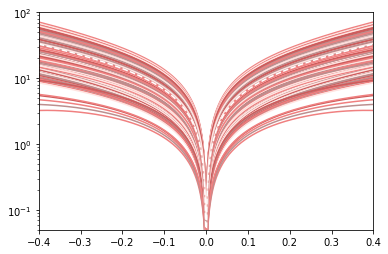

In [14]:
plt.gca().set_prop_cycle(color=['rosybrown', 'lightcoral', 'indianred', 'mistyrose'])
I_m = np.zeros([steps,])
for j in range(n):
    memristor = StaticMemristor(g_0[j])
    memristor.calibrate(temperature, frequency)
    I = [memristor.inference(v) for v in np.linspace(v_range[0], v_range[1], steps)]
    I_m += I
    plt.plot(np.linspace(v_range[0], v_range[1], steps), np.abs(I)*1e6, label=f"simulation {j}")
plt.plot(np.linspace(v_range[0], v_range[1], steps), np.abs(I_m/n)*1e6, '--',color = 'white')
plt.yscale('log')
plt.ylim([0.05, 100])
plt.xlim([-0.4, 0.4])
fig = plt.gcf()
fig.savefig('ivcurve.png', dpi=100)
plt.show()

#### Conductance Update Curve

In [66]:
g_0 = 65e-6
temperature = 60
frequency = 1e8
n=5
v_p_all=[1.15, 0.9, -1.1, -1.4]#[1.15, 1, -1.1, -1.4]
t_p_all=[5e-3, 5e-3, 10e-3, 10e-3]#[0.5e-3, 0.5e-3, 1e-3, 1e-3]
colors = ["lightblue", "orange", "gray", "pink"]
iteration = 75

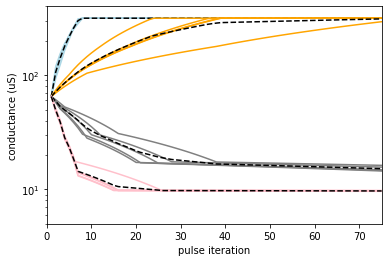

In [67]:
for i in range(len(v_p_all)):
    v_p, t_p = v_p_all[i], t_p_all[i]
    OPERATION = "SET" if v_p > 0 else "RESET"
    mean_conductances = np.zeros([iteration,])
    for j in range(n):
        memristor = DynamicMemristor(g_0)
        memristor.calibrate(temperature, frequency)
        conductances = [float(memristor.g_0)*1e6]
        for k in range(iteration-1):
            #print("iteration:", k, OPERATION, v_p)
            if OPERATION == "SET":
                memristor.set(v_p, t_p)
            elif OPERATION == "RESET":
                memristor.reset(v_p, t_p)
            else:
                raise ValueError("UNKNOWN OPERATION")
            memristor.calibrate(temperature, frequency)
            conductances.append(float(memristor.g_0)*1e6)
        mean_conductances += np.array(conductances)
        plt.plot(range(1, iteration+1), conductances, colors[i])
    plt.plot(range(1, iteration+1), mean_conductances/n, '--', color = "black")
    

    #plt.text(0, 78, f'g_0: {g_0 * 1e6} uS\n t_p: {t_p * 1e3} ms\n v_p: {v_p} V', fontsize=11)
plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([5,400])
plt.xlim([0, iteration])
fig = plt.gcf()
fig.savefig('conductanceupdate.png', dpi=100)
plt.show()

#### Single Device Conductance Cycle to Cycle Variability

In [62]:
g_0 = 65e-6
temperature = 60
frequency = 1e8
n=5
v_set = 0.9
v_reset = -1.1
t_p_set = 0.25
t_p_reset = 0.5
n_set = 5
n_reset = 10
cycles = 6

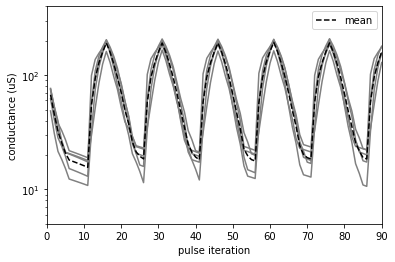

In [71]:
conductance_hist = np.zeros([n, cycles*(n_set+n_reset)])
memristors = [DynamicMemristor(g_0) for i in range(n)]
_ = [memristor.calibrate(temperature, frequency) for memristor in memristors]
for i in range(cycles):
    for j in range(n):
        conductances = []
        memristor = memristors[j]
        for k in range(n_reset):
            conductances.append(float(memristor.g_linfit)*1e6)
            memristor.reset(v_reset, t_p_reset)
            memristor.calibrate(temperature, frequency)
        for k in range(n_set):
            conductances.append(float(memristor.g_linfit)*1e6)
            memristor.set(v_set, t_p_set)
            memristor.calibrate(temperature, frequency)
        conductance_hist[j, i*(n_reset+n_set):(i+1)*(n_reset+n_set)] = np.array(conductances)
        
# plot all
for i in range(n):
    plt.plot(range(1, cycles*(n_set+n_reset)+1), conductance_hist[i,:], color="gray")
plt.plot(range(1, cycles*(n_set+n_reset)+1), np.mean(conductance_hist, axis=0), '--', color = "black", label = "mean")
plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([5,400])
plt.xlim([0, cycles*(n_set+n_reset)])
plt.legend()
fig = plt.gcf()
fig.savefig('single_conductance_cycle.png', dpi=100)
plt.show()

In [76]:
g_0 = 65e-6
temperature = 60
frequency = 1e8
n=5
v_set = 0.8
v_reset = -1.0
t_p_set = 0.25
t_p_reset = 0.5
n_set = 5
n_reset = 10
cycles = 6

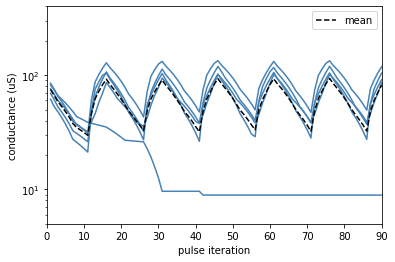

In [77]:
conductance_hist = np.zeros([n, cycles*(n_set+n_reset)])
memristors = [DynamicMemristor(g_0) for i in range(n)]
_ = [memristor.calibrate(temperature, frequency) for memristor in memristors]
for i in range(cycles):
    for j in range(n):
        conductances = []
        memristor = memristors[j]
        for k in range(n_reset):
            conductances.append(float(memristor.g_linfit)*1e6)
            memristor.reset(v_reset, t_p_reset)
            memristor.calibrate(temperature, frequency)
        for k in range(n_set):
            conductances.append(float(memristor.g_linfit)*1e6)
            memristor.set(v_set, t_p_set)
            memristor.calibrate(temperature, frequency)
        conductance_hist[j, i*(n_reset+n_set):(i+1)*(n_reset+n_set)] = np.array(conductances)
        
# plot all
for i in range(n):
    plt.plot(range(1, cycles*(n_set+n_reset)+1), conductance_hist[i,:], color="steelblue")
plt.plot(range(1, cycles*(n_set+n_reset)+1), np.mean(conductance_hist, axis=0), '--', color = "black", label = "mean")
plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([5,400])
plt.xlim([0, cycles*(n_set+n_reset)])
plt.legend()
fig = plt.gcf()
fig.savefig('single_conductance_cycle2.png', dpi=100)
plt.show()

In [84]:
g_0 = 65e-6
temperature = 60
frequency = 1e8
n=5
v_set_all = [0.95, 0.9, 0.8]
v_reset_all = [-1.15, -1.1, -1.0]
t_p_set = 0.25
t_p_reset = 0.5
n_set = 5
n_reset = 10
cycles = 4
colors = ["gray", "lightcoral", "steelblue"]

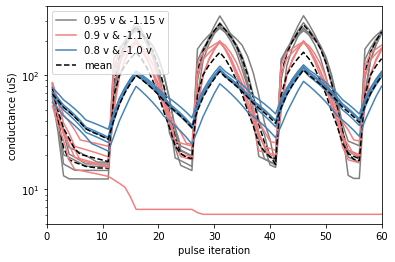

In [85]:
for c in range(len(colors)):
    v_set = v_set_all[c]
    v_reset = v_reset_all[c]
    conductance_hist = np.zeros([n, cycles*(n_set+n_reset)])
    memristors = [DynamicMemristor(g_0) for i in range(n)]
    _ = [memristor.calibrate(temperature, frequency) for memristor in memristors]
    for i in range(cycles):
        for j in range(n):
            conductances = []
            memristor = memristors[j]
            for k in range(n_reset):
                conductances.append(float(memristor.g_linfit)*1e6)
                memristor.reset(v_reset, t_p_reset)
                memristor.calibrate(temperature, frequency)
            for k in range(n_set):
                conductances.append(float(memristor.g_linfit)*1e6)
                memristor.set(v_set, t_p_set)
                memristor.calibrate(temperature, frequency)
            conductance_hist[j, i*(n_reset+n_set):(i+1)*(n_reset+n_set)] = np.array(conductances)

    # plot all
    for i in range(n):
        if i == n-1:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), conductance_hist[i,:], color=colors[c], label = f"{v_set_all[c]} v & {v_reset_all[c]} v")
        else:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), conductance_hist[i,:], color=colors[c])
    if c == len(colors)-1:
        plt.plot(range(1, cycles*(n_set+n_reset)+1), np.mean(conductance_hist, axis=0), '--', color = "black", label="mean")
    else:
        plt.plot(range(1, cycles*(n_set+n_reset)+1), np.mean(conductance_hist, axis=0), '--', color = "black")

plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([5,400])
plt.xlim([0, cycles*(n_set+n_reset)])
plt.legend(loc = "upper left")
fig = plt.gcf()
fig.savefig('multiple_conductance_cycle.png', dpi=100)
plt.show()

In [139]:
n = 200
steps = 500
g_0 = np.concatenate([20 * np.ones([40,]), 40 * np.ones([40,]), 60 * np.ones([40,]), 80 * np.ones([40,]), 100 * np.ones([40,])])*1e-6
temperature = 85
frequency = 1e8
v_range = [-0.4,0.4]

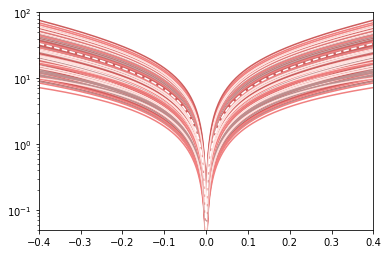

In [140]:
plt.gca().set_prop_cycle(color=['rosybrown', 'lightcoral', 'indianred', 'mistyrose'])
I_m = np.zeros([steps,])
for j in range(n):
    memristor = StaticMemristor(g_0[j])
    memristor.calibrate(temperature, frequency)
    I = [memristor.inference(v) for v in np.linspace(v_range[0], v_range[1], steps)]
    I_m += I
    plt.plot(np.linspace(v_range[0], v_range[1], steps), np.abs(I)*1e6, label=f"simulation {j}")
plt.plot(np.linspace(v_range[0], v_range[1], steps), np.abs(I_m/n)*1e6, '--',color = 'white')
plt.yscale('log')
plt.ylim([0.05, 100])
plt.xlim([-0.4, 0.4])
plt.show()

In [141]:
g_0 = 65e-6
temperature = 60+273
frequency = 1e8
n=5
v_p_all=[1.15, 0.9, -1.1, -1.4]#[1.15, 1, -1.1, -1.4]
t_p_all=[5e-3, 5e-3, 10e-3, 10e-3]#[0.5e-3, 0.5e-3, 1e-3, 1e-3]
colors = ["lightblue", "orange", "gray", "pink"]
iteration = 75

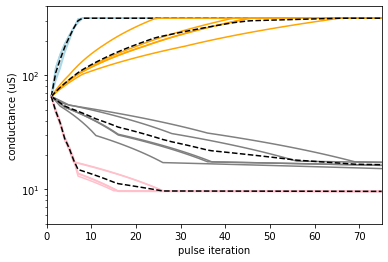

In [142]:
for i in range(len(v_p_all)):
    v_p, t_p = v_p_all[i], t_p_all[i]
    OPERATION = "SET" if v_p > 0 else "RESET"
    mean_conductances = np.zeros([iteration,])
    for j in range(n):
        memristor = DynamicMemristor(g_0)
        memristor.calibrate(temperature, frequency)
        conductances = [float(memristor.g_0)*1e6]
        for k in range(iteration-1):
            #print("iteration:", k, OPERATION, v_p)
            if OPERATION == "SET":
                memristor.set(v_p, t_p)
            elif OPERATION == "RESET":
                memristor.reset(v_p, t_p)
            else:
                raise ValueError("UNKNOWN OPERATION")
            memristor.calibrate(temperature, frequency)
            conductances.append(float(memristor.g_0)*1e6)
        mean_conductances += np.array(conductances)
        plt.plot(range(1, iteration+1), conductances, colors[i])
    plt.plot(range(1, iteration+1), mean_conductances/n, '--', color = "black")
    

    #plt.text(0, 78, f'g_0: {g_0 * 1e6} uS\n t_p: {t_p * 1e3} ms\n v_p: {v_p} V', fontsize=11)
plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([5,400])
plt.xlim([0, iteration])
plt.show()

In [10]:
g_0 = 65e-6
temperature = 273+60
frequency = 1e8
n=5
v_set_all = [0.95, 0.9, 0.8]
v_reset_all = [-1.15, -1.1, -1.0]
t_p_set = 0.25
t_p_reset = 0.5
n_set = 5
n_reset = 10
cycles = 4
colors = ["gray", "lightcoral", "steelblue"]

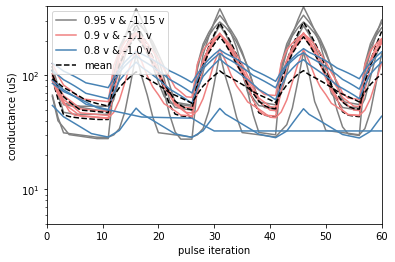

In [11]:
for c in range(len(colors)):
    v_set = v_set_all[c]
    v_reset = v_reset_all[c]
    conductance_hist = np.zeros([n, cycles*(n_set+n_reset)])
    memristors = [DynamicMemristor(g_0) for i in range(n)]
    _ = [memristor.calibrate(temperature, frequency) for memristor in memristors]
    for i in range(cycles):
        for j in range(n):
            conductances = []
            memristor = memristors[j]
            for k in range(n_reset):
                conductances.append(float(memristor.g_linfit)*1e6)
                memristor.reset(v_reset, t_p_reset)
                memristor.calibrate(temperature, frequency)
            for k in range(n_set):
                conductances.append(float(memristor.g_linfit)*1e6)
                memristor.set(v_set, t_p_set)
                memristor.calibrate(temperature, frequency)
            conductance_hist[j, i*(n_reset+n_set):(i+1)*(n_reset+n_set)] = np.array(conductances)

    # plot all
    for i in range(n):
        if i == n-1:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), conductance_hist[i,:], color=colors[c], label = f"{v_set_all[c]} v & {v_reset_all[c]} v")
        else:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), conductance_hist[i,:], color=colors[c])
    if c == len(colors)-1:
        plt.plot(range(1, cycles*(n_set+n_reset)+1), np.mean(conductance_hist, axis=0), '--', color = "black", label="mean")
    else:
        plt.plot(range(1, cycles*(n_set+n_reset)+1), np.mean(conductance_hist, axis=0), '--', color = "black")

plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([5,400])
plt.xlim([0, cycles*(n_set+n_reset)])
plt.legend(loc = "upper left")
plt.show()